### This notebook is extended from QCloudSim - Hetrogeneous. We are currently testing with geneva nosie data. 

In [2]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from QJob import QJob
from JobLogger import JobLogger
from helperfun import *
from helperfun import INTERVAL
from datetime import datetime

In [3]:
class QCloud(object):

    """
    A quantum cloud or a QCloud has a number of unique devices. Each device has certain properties. 
    QCloud has only one property that is to execute the qjob (or quantum job) that the broker 
    assigns to a certain device. 

    """
    
    def __init__(self, env, num_qdevices):
        """ simulation environment (env) and quantum devices (simpy.PriorityResource)
            are declared at initialization. 
        
        """
        self.env = env
        self.num_qdevices = num_qdevices
        
        self.geneva = simpy.PriorityResource(env=env, capacity=1)
        self.hanoi = simpy.PriorityResource(env=env, capacity=1)
        self.montreal = simpy.PriorityResource(env=env, capacity=1)
        self.mumbai = simpy.PriorityResource(env=env, capacity=1)
        self.toronto = simpy.PriorityResource(env=env, capacity=1)
        
        self.qdevicesList = [self.geneva, self.hanoi, self.montreal, self.mumbai, self.toronto]
        self.qdevicesName = ['geneva', 'hanoi', 'montreal', 'mumbai', 'toronto']
        
        """IBM does not provide specific CLOPS. While IBM does provide various metrics 
           and specifications for their quantum devices, CLOPS is not typically one of them. """
        
        self.CLOPS = {'geneva': random.randint(4000, 5000), 
                      'hanoi': random.randint(4800, 5000), 
                      'montreal': random.randint(4600, 4900), 
                      'mumbai': random.randint(4200, 4800), 
                      'toronto': random.randint(4100, 4800)}
        
        self.life_time = {'geneva': 4000, 
                              'hanoi': 1500, 
                              'montreal': 4500, 
                              'mumbai': 6000, 
                              'toronto': 2000}
        
        self.ori_life_time = {'geneva': 4000, 
                              'hanoi': 1500, 
                              'montreal': 4500, 
                              'mumbai': 6000, 
                              'toronto': 2000}
        
    def execute(self, qjob, qdevID):
        """ execute function take a quantum job (qjob) and process. """
        device_name = self.qdevicesName[qdevID]
        CLOPS = self.CLOPS[device_name] 
        est_time = estimate_time(qjob, self.qdevicesName[qdevID], CLOPS)
        
        printLog(f'Sim time {self.env.now:.2f}: Qjob {qjob._id}\'s estimate time is {est_time:.2f}.', PrintLog = False)
        yield self.env.timeout(est_time)
        
        prob_meas0_prep1 = estimate_success_probability(qjob.num_of_circuit, device_name)

        printLog(f'Sim time {self.env.now:.2f}: Qjob {qjob._id} with {qjob.num_of_qubits} qubits processed with {prob_meas0_prep1 * 100:.2f}% of PST.', PrintLog = False)
        printLog(f'Sim time {self.env.now:.2f}: Qjob {qjob._id} left {device_name}.', PrintLog = False)  
        
        self.life_time[device_name] -= est_time # replace this with shots

In [4]:
class Broker(object):
    """ 
    Broker is responsible for assigning quantum jobs (qjobs) to an appropriate qdevice. 
    The goal of a broker is to utilize available quantum devices at QCloud. 
    
    """
    def __init__(self, env, prioritize):
        self.env = env
        self.prioritize = prioritize
        
    def schedule(self, qcloud, qjob, joblogger): 
        
        """
        Schedule layer is where all the qjobs arrive. Broker keeps qjobs in the central queue. 
        By default, broker provides a simple FIFO scheduling algorithm. The users can implement 
        their own scheduling algorithm. 
        
        """
        printLog(f'Sim time {self.env.now:.2f}: {qjob._id} arrives at the central queue.', PrintLog = False)
        arrival_time = self.env.now
        
        if not self.prioritize: 
            qjob.priority = 2
        
        ### scheduling policies
        rotate = False

        if rotate: 
            ## rotate machine        
            qdevID = qjob._id%qcloud.num_qdevices
        else: 
            ## get a random machine
            qdevID = random.randint(0, qcloud.num_qdevices-1)       
        
        ### assign the job to a specific device
        with qcloud.qdevicesList[qdevID].request(priority = qjob.priority) as request:
            yield request
            
            wait_time = self.env.now - arrival_time
            joblogger.wait_time.append(wait_time)
            device_name = qcloud.qdevicesName[qdevID]   
            
            printLog(f'Sim time {self.env.now:.2f}: Qjob {qjob._id} is assigned to {device_name} with priority {qjob.priority}.', PrintLog = False)
            yield self.env.process(qcloud.execute(qjob, qdevID))
            
            joblogger.num_of_completed_jobs += 1
            
            life_time = qcloud.life_time[device_name]
            
            printLog(f'Sim time {self.env.now:.2f}: Life time of {device_name} is {life_time:.2f}.', PrintLog)
            
            if life_time < 0: 
                printLog(f'Sim time {self.env.now:.2f}: Life time of {device_name} is {life_time:.2f}.', PrintLog)
                printLog(f'Sim time {self.env.now:.2f}: Maintenance needed for {device_name}.', PrintLog)
                yield env.timeout(900) # maintenance time 
                qcloud.life_time[device_name] = qcloud.ori_life_time[device_name]
                printLog(f'Sim time {self.env.now:.2f}: Maintenance finished for {device_name}.', PrintLog)

In [5]:
def setup(env, num_machines, joblogger):
    """Setup initializes a quantum cloud, a broker and job generator generating 
    jobs in approx. every INTERVAL minutes."""
    
    # initialize a quantum cloud
    qcloud = QCloud(env, num_machines)
    
    # initialize a broker
    # set prioritize = True for priority scheduling
    # False for FIFO scheduling
    
    broker = Broker(env = env, prioritize = False)
    
    # Create jobs while the simulation is running
    i = 0
    while True:
        yield env.timeout(incoming_job_interval())
        i += 1
        qjob = QJob(env, i)
        env.process(broker.schedule(qcloud, qjob, joblogger))   
    

In [9]:
data = {}

SIM_TIME = 10000
PrintLog = True # Detail Logs
NUM_OF_MACHINE = 5
# Setup and start the simulation
print(f'Simulation Started at {datetime.now()}')
sim_start_time = time.time()

for NUM_MAC in range(1, NUM_OF_MACHINE+1): 
    RANDOM_SEED = random.randint(2, 10000)
    random.seed(RANDOM_SEED)  # This helps to reproduce the results

    joblogger = JobLogger()

    # Create an environment and start the setup process
    env = simpy.Environment()
    env.process(setup(env, NUM_MAC, joblogger))

    # Execute!
    env.run(until=SIM_TIME)
    data[NUM_MAC] = joblogger.wait_time
    print(f'Number of Machine: {NUM_OF_MACHINE} - Sim time taken - {env.now:.2f}')

print(f'Simulation Ended at {datetime.now()}')
sim_end_time = time.time()
print(f'Elasped time - {sim_end_time-sim_start_time:.5f}')

Simulation Started at 2024-03-30 21:38:23.127045
Sim time 106.91: Life time of geneva is 3905.10.
Sim time 131.24: Life time of geneva is 3880.78.
Sim time 194.83: Life time of geneva is 3817.19.
Sim time 230.66: Life time of geneva is 3781.35.
Sim time 300.86: Life time of geneva is 3711.16.
Sim time 379.40: Life time of geneva is 3632.61.
Sim time 429.84: Life time of geneva is 3582.18.
Sim time 450.82: Life time of geneva is 3561.20.
Sim time 483.75: Life time of geneva is 3528.26.
Sim time 503.90: Life time of geneva is 3508.12.
Sim time 605.54: Life time of geneva is 3406.48.
Sim time 638.97: Life time of geneva is 3373.04.
Sim time 681.36: Life time of geneva is 3330.66.
Sim time 737.89: Life time of geneva is 3274.13.
Sim time 803.98: Life time of geneva is 3208.04.
Sim time 848.05: Life time of geneva is 3163.97.
Sim time 917.95: Life time of geneva is 3094.06.
Sim time 963.41: Life time of geneva is 3048.61.
Sim time 1000.91: Life time of geneva is 3011.11.
Sim time 1069.09: L

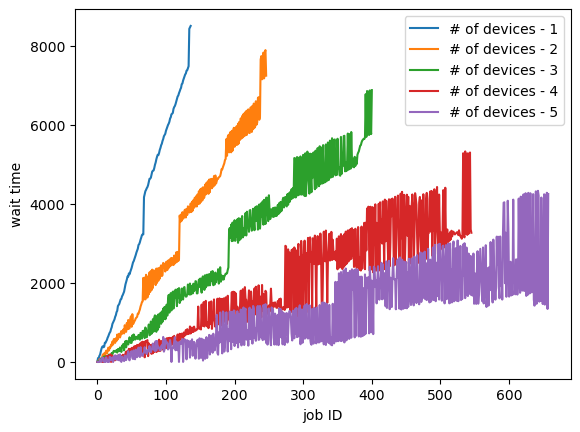

In [10]:
## Plotting the data

for i in range(1, NUM_OF_MACHINE+1): 
    plt.plot(data[i])

plt.legend(['# of devices - 1', 
            '# of devices - 2', '# of devices - 3', 
            '# of devices - 4', '# of devices - 5', 
            '# of devices - 6', '# of devices - 7', 
            '# of devices - 8', '# of devices - 9'])
plt.xlabel('job ID')
plt.ylabel('wait time')
plt.show()